# Example script for solving the Gross-Pitaevskii Equation with time splitting pseudospectral methods

In [1]:
import os

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random
import numpy as np

In [3]:
from jax_pf import domains

from jax_pf import equations
from jax_pf.timestepping import strange_splitting

from jax_pf.simutils import set_up_timestepping, set_up_simulation, initialize_Psi

Function for computing density from wavefunction

In [4]:
def density(psi):
    return jnp.abs(psi)**2

Define physical variables for the problem

In [5]:
# Get variables with dimensions
L = 150e-6 #meters
atoms = 5e5
hbar = 1.05e-34 #J*s
omega = 2*jnp.pi*10 #1/s
omega_z = jnp.sqrt(8)*omega #1/s
Omega = 2*jnp.pi #1/s
epsilon = 0.0
mass = 3.8175406e-26 #kg (atomic mass of sodium-23)
a0 = 5.29177210903e-11
a_s = 100*a0
N = 256

Define time and length scales

In [6]:
x_s = jnp.sqrt(hbar/(mass*omega))
t_s = 1/omega

Get dimensionless variables, _ indicates a dimensionless quantity.

In [7]:
L_ = float(L/x_s)
Omega_ = Omega/omega

Get dimensionless coupling constant

In [8]:
k = 4*jnp.pi*a_s*atoms*jnp.sqrt((mass*omega_z)/(2*jnp.pi*hbar))

Get the ratio of the ellipse

In [9]:
epsilon = 0.0

Create the domain

In [10]:
# Create domain
domain_ = domains.Domain((N,N,), ((-L_/2, L_/2), (-L_/2, L_/2),), "dimensionless")
print(domain_)

Domain with bounds ((-11.335701942443848, 11.335701942443848), (-11.335701942443848, 11.335701942443848)) with units of dimensionless and (256, 256) collocation points.


Getting times of simulation

In [11]:
t_start = 0.0
t_final = 0.04
dt = 1e-5
save_at = 0.001

t_start_ = t_start/t_s
t_final_ = t_final/t_s
dt_ = dt/t_s
save_at_ = save_at/t_s

checkpoints = [int(save_at_ // dt_)]

t_final_, num_steps, write_every, out_states, ts_ = set_up_timestepping(t_start_, t_final_, dt_, save_at_, checkpoints)

Get initial condition for simulation

In [31]:
Psi0 = initialize_Psi(N, width=100, vortexnumber=0)
Psi0_ = Psi*x_s
Psi0_ /= jnp.sqrt(jnp.sum(density(Psi0_))*domain_.dx[0]**2)

Display initial condition

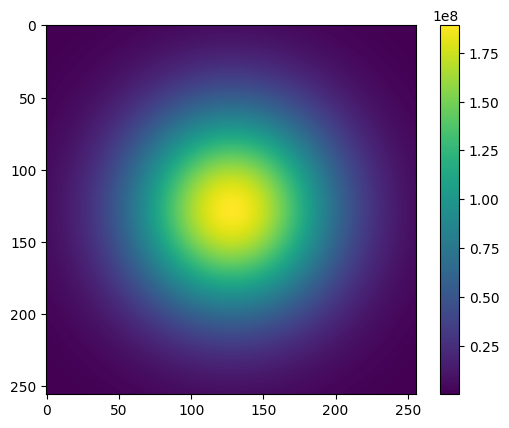

In [32]:
plt.imshow(density(Psi0_/x_s))
plt.colorbar()

Define equations to simulate and use imaginary time evolution

In [33]:
eq = equations.GPE2DTSControl(domain_, k, epsilon, lambda a,b,c: 0.0, False)
stepfn = strange_splitting(eq, -dt_*1j)

Create simulation function

In [34]:
sim_func = set_up_simulation(eq, stepfn, t_start_, t_final_, dt_, save_at_, write_every, out_states, checkpoints)

Run simulation

In [36]:
u_traj = sim_func(Psi0_)

print(f"Final density is: {jnp.sum(density(u_traj[-1]))*domain_.dx[0]**2}")

Final density is: 0.9999726414680481


Plot result

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kwargs)>

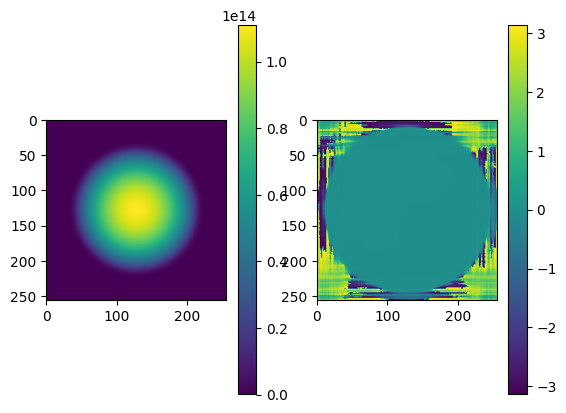

In [37]:
plt.subplot(1,2,1)
plt.imshow(density(u_traj[-1]/x_s)*atoms)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(jnp.angle(u_traj[-1]))
plt.colorbar()
plt.colorbar

## Now introduce a rotating light control

In [38]:
def light(t, p, xs, ys):
    res = jnp.zeros(xs.shape, dtype=xs.dtype)
    for i in range(0, p.shape[0], 5):
        xi, yi = p[i+2]*jnp.cos(p[i+3]*t-p[i+4]), p[i+2]*jnp.sin(p[i+3]*t-p[i+4])
        res += p[i]*jnp.exp(-((xs-xi)**2 + (ys-yi)**2)/(2.0*p[i+1]))
    return res

Define parameters for the lights

In [39]:
sigma = 2e-6 #meters
A = 30.0 #need to do energy nondim

sigma_ = sigma/x_s
A_ = A #need to do energy nondim

params = jnp.array([A_, sigma_**2, 30e-6/x_s, 5*Omega_, 0.0,  
                    A_, sigma_**2, 40e-6/x_s, 5*Omega_, 0.0,
                    A_, sigma_**2, 20e-6/x_s, 5*Omega_, 1.0])

In [40]:
light_ = lambda t, xmesh, ymesh: light(t, params, xmesh, ymesh)

Getting times of simulation

In [41]:
t_start = 0.0
t_final = 1.0
dt = 1e-5
save_at = 0.01

cooling = 0.01

t_start_ = t_start/t_s
t_final_ = t_final/t_s
dt_ = dt/t_s
save_at_ = save_at/t_s

checkpoints = [int(save_at_ // dt_)]

t_final_, num_steps, write_every, out_states, ts_ = set_up_timestepping(t_start_, t_final_, dt_, save_at_, checkpoints)

Define equations to solve

In [42]:
eq = equations.GPE2DTSControl(domain_, k, epsilon, light_, False)
stepfn = strange_splitting(eq, dt_*(1.0 - 1j*cooling))

In [43]:
sim_func = set_up_simulation(eq, stepfn, t_start_, t_final_, dt_, save_at_, write_every, out_states, checkpoints)

In [45]:
u_traj2 = sim_func(u_traj[-1])

print(f"Final density is {jnp.sum(density(u_traj2[-1]))*domain_.dx[0]**2}")

Final density is 0.9999926686286926


Plot final state

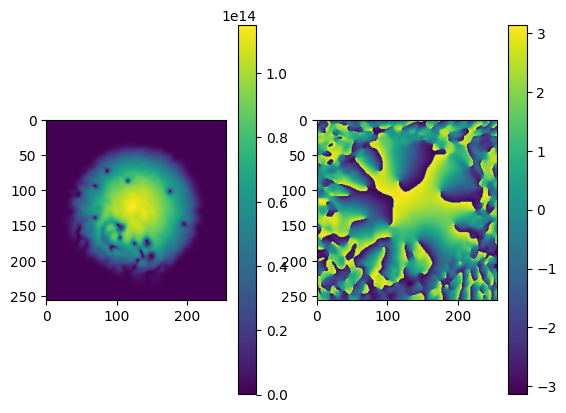

In [46]:
ind = -1
plt.subplot(1,2,1)
plt.imshow(atoms*density(u_traj2[ind]/x_s))
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(jnp.angle(u_traj2[ind]))
plt.colorbar()